In [128]:
import pandas as pd

nifty50_df = pd.read_csv('nifty50.csv')

replaced_tickers = pd.read_csv('nifty50_changes.csv')
stock_changes = pd.read_csv('nifty50_changes.csv')
stock_changes['start_date'] = pd.to_datetime(stock_changes['start_date'])
stock_changes['end_date'] = pd.to_datetime(stock_changes['end_date'])

tickers = [f"NSE:{t}-EQ" for t in set(nifty50_df['Symbol'].tolist())] + stock_changes.symbol.tolist()

In [129]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "/workspaces/codespaces-jupyter/data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Error fetching data for NSE:HDFC-EQ: 'candles'


Loading 1Dmin data: 100%|██████████| 62/62 [00:01<00:00, 53.64it/s]


In [130]:
df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()

In [131]:
import talib as ta

df.Date = pd.to_datetime(df.Date)
# Calculate RSI per stock
df['SMA20'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=20))
df['SMA20_Perc_Distance'] = (df['Close'] - df['SMA20']) / df['SMA20'] * 100

df['Entry_Price'] = df.groupby('Stock')['Close'].shift(-1)
df['Entry_Time'] = df.groupby('Stock')['Date'].shift(-1)

# df = df[df.Date >= '2020-01-01 05:30:00']

In [132]:
signals = (
    df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))
      .sort_values(['Date', 'SMA20_Perc_Distance']).reset_index(drop=True).dropna(subset=['Entry_Price'])
)

/tmp/ipykernel_4797/960733863.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))


In [165]:
from dataclasses import dataclass, field, asdict
from typing import List
from uuid import uuid1
from tqdm.notebook import tqdm
from copy import copy


leverage = 1
tp_perc = 3.14
sl_perc = 20
rebalance_perc = 3
active_positions = {}
closed_positions = []
initial_capital = 1000000
max_positions_num = 10
max_holding_period = 5000  # days
max_num_of_avgs = 3
mtf_rate_daily = 0.0192 / 100  # Margin funding rate (per day)

class Bank:
    initial_capital: float
    buckets: dict = {}
    ids: list = []
    residue: dict = {}
    snapshot: list = []
    bucket_usage_count: dict = {}

    def __init__(self, initial_capital, number_of_buckets = 10) -> None:
        self.initial_capital = initial_capital
        self.ids = [str(uuid1()).split('-')[0] for i in range(number_of_buckets)]
        self.buckets = dict(zip(self.ids, [initial_capital/number_of_buckets] * number_of_buckets))

    def borrow(self) -> tuple:
        if len(self.buckets) == 0:
            return None, None
        
        _df = pd.DataFrame(self.buckets.items(), columns=['key', 'amount']).sort_values('amount', ascending=True)
        key = _df.iloc[0].key
        bucket_amount = self.buckets.pop(key)

        self.bucket_usage_count[key] = self.bucket_usage_count.get(key, 0) + 1
        self._take_snapshot()
        return key, bucket_amount
    
    def save_residue(self, key, amount):
        self.residue[key] = amount

    def _take_snapshot(self):
        self.snapshot.append(copy(self.buckets))
    
    def settle(self, key, amount):
        if key not in self.ids:
            raise Exception("invalid key")
        residue = self.residue.pop(key)
        self.buckets[key] = amount + residue
        self._take_snapshot()


@dataclass
class Trade:
    capital_key: str
    entry_time: str
    entry_price: float
    quantity: int

@dataclass
class Position:
    stock: str
    entry_time: pd.Timestamp
    avg_entry_price: float = 0.0
    last_entry_price: float = 0.0
    quantity: int = 0
    exit_time: pd.Timestamp | None = None
    exit_price: float = 0.0
    tp: float = 0.0
    sl: float = 0.0
    trades: List[Trade] = field(default_factory=list)
    pnl: float = 0.0
    tax: float = 0.0

    def exit_margin(self):
        return (self.exit_price * self.quantity)/leverage - self.tax

    def close(self, exit_time, exit_price):
        self.exit_time = exit_time
        self.exit_price = exit_price
        if self.quantity < 0:
            print(self)
            raise Exception("Quantity can't be negative")
        self.pnl = (exit_price - self.avg_entry_price) * self.quantity
        self.calculate_taxes()

    def calculate_taxes(self):
        extry_taxes = 0
        for trade in self.trades:
            stt = abs(trade.quantity) * trade.entry_price * 0.025/100
            transaction_charges = (abs(trade.quantity) * trade.entry_price * 0.00322/100)
            gst = (stt + transaction_charges) * 18/100
            extry_taxes += stt + transaction_charges + gst

        transaction_charges = abs(self.quantity) * self.exit_price * 0.00322/100
        gst = transaction_charges * 18/100
        stamp_duty = abs(self.quantity) * self.exit_price * 0.003/100
        exit_taxes = transaction_charges + gst + stamp_duty

        # --- Add MTF charge ---
        holding_days = (self.exit_time - self.entry_time).days
        holding_days = min(holding_days, 100)
        mtf_funded_amount = self.avg_entry_price * self.quantity * (leverage - 1) / leverage
        mtf_charge = mtf_funded_amount * mtf_rate_daily * holding_days

        self.tax = extry_taxes + exit_taxes + mtf_charge

    def rebalance_position(self):
        total_cost = 0
        total_qty = 0
        for t in self.trades:
            total_cost += t.entry_price * t.quantity
            total_qty += t.quantity
        if total_qty == 0:
            print(self)
        self.avg_entry_price = total_cost / total_qty
        self.quantity = total_qty
        self.tp = self.avg_entry_price * (1 + tp_perc / 100)
        self.sl = self.avg_entry_price * (1 - sl_perc / 100)
        self.last_entry_price = self.trades[-1].entry_price if len(self.trades) > 0 else 0

    def add_trade(self, trade: Trade):
        self.trades.append(trade)
        self.rebalance_position()

def select_stock_for_entry(signals: pd.DataFrame):
    selected_stocks = []
    for _, signal in signals.iterrows():
        if active_positions.get(signal.Stock, None) is None:
            if signal.Stock in stock_changes.symbol.tolist():
                stock = stock_changes[stock_changes.symbol == signal.Stock]
                if signal.Date >= stock.start_date.values[0] and signal.Date <= stock.end_date.values[0]:
                    selected_stocks.append(signal)
            else:
                selected_stocks.append(signal)
    return selected_stocks[0] if len(selected_stocks) > 0 else None


def init_new_position(k, v):
    selected_stock = select_stock_for_entry(signals[signals.Date == k])
    if selected_stock is None:
        return None
        
    key, capital = bank.borrow()
    if key is None:
        return None
        
    if selected_stock is not None:
        qty = int(capital * leverage / selected_stock.Entry_Price)
        if qty < 0:
            key, capital = bank.borrow()
            if key is None:
                return None
            qty = int(capital * leverage / selected_stock.Entry_Price)
            # raise Exception("Quantity can't be negative")

        if qty == 0:
            return None
        position = Position(selected_stock.Stock, selected_stock.Entry_Time)
        trade = Trade(key, selected_stock.Entry_Time, selected_stock.Entry_Price, qty)
        position.add_trade(trade)

        bank.save_residue(key, capital - (qty * trade.entry_price) / leverage)
        return position

def avg_out_active_positions(k, v):
    global active_positions, capital_buckets, max_num_of_avgs
    if not has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in active_positions.values() if p is not None]).set_index('stock')
        .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Close', 'Entry_Time', 'Entry_Price']])
    )
    apdf['perc_change'] = (apdf.Close - apdf.last_entry_price)/apdf.last_entry_price * 100
    rebalance_stocks = apdf[apdf.perc_change <= -rebalance_perc].sort_values('perc_change')
    if len(rebalance_stocks) == 0:
        return

    for k, stock in rebalance_stocks.iterrows():
        position = active_positions[stock.name]
        if len(position.trades) == max_num_of_avgs:
            continue

        key, capital = bank.borrow()
        if key is None:
            return
        
        qty = position.quantity / len(position.trades)

        trade = Trade(key, stock.Entry_Time, stock.Entry_Price, qty)
        position.add_trade(trade)
        
        bank.save_residue(key, capital - (qty * trade.entry_price)/ leverage)
        break

def book_profit(k, v):
    if not has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in active_positions.values() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['High', 'Close', 'Date']])
    )
    apdf = apdf[apdf.High >= apdf.tp]
    apdf['perc_change'] = (apdf.Close - apdf.avg_entry_price)/apdf.avg_entry_price * 100

    selected_stocks = apdf.sort_values('perc_change', ascending=False)
    if len(selected_stocks) > 0:
        selected_stock = selected_stocks.iloc[0]
        position = active_positions[selected_stock.name]
        position.close(selected_stock.Date, selected_stock.tp)
        closed_positions.append(position)
        active_positions[position.stock] = None

        exit_margin = position.exit_margin() / len(position.trades)
        for trade in position.trades:
            bank.settle(trade.capital_key, exit_margin)

def get_active_positions():
    return [p for p in active_positions.values() if p is not None]

def has_active_positions():
    return len(get_active_positions()) > 0

def exit_long_running_positions(k, v):
    global active_positions
    if not has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in active_positions.values() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Date', 'Close']])
    )
    apdf['holding_period'] = (k - apdf.entry_time).dt.days
    long_running_positions = apdf[apdf.holding_period >= max_holding_period]
    
    for stock, lr_position in long_running_positions.iterrows():
        position = active_positions[stock]
        position.close(lr_position.Date, lr_position.Close)
        closed_positions.append(position)
        active_positions[position.stock] = None

        exit_margin = position.exit_margin() / len(position.trades)
        for trade in position.trades:
            bank.settle(trade.capital_key, exit_margin)

def book_loss(k, v):
    if not has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in active_positions.values() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Low', 'Close', 'Date']])
    )
    apdf = apdf[apdf.Low <= apdf.sl]
    apdf['perc_change'] = (apdf.avg_entry_price - apdf.Close)/apdf.avg_entry_price * 100

    selected_stocks = apdf.sort_values('perc_change', ascending=False)
    for selected_stock in selected_stocks.itertuples():
        position = active_positions[selected_stock.Index]
        position.close(selected_stock.Date, selected_stock.sl)
        closed_positions.append(position)
        active_positions[position.stock] = None

        exit_margin = position.exit_margin() / len(position.trades)
        for trade in position.trades:
            bank.settle(trade.capital_key, exit_margin)

def exit_if_removed_from_index(k, v):
    global active_positions
    if not has_active_positions():
        return

    for p in get_active_positions():
        if p.stock not in stock_changes.symbol.tolist():
            continue
        stock = stock_changes[stock_changes.symbol == p.stock]
        if k > stock.end_date.values[0]:
            position = active_positions[p.stock]
            position.close(k, v[v.Stock == p.stock].Close.values[0])
            closed_positions.append(position)
            active_positions[position.stock] = None

            exit_margin = position.exit_margin() / len(position.trades)
            for trade in position.trades:
                bank.settle(trade.capital_key, exit_margin)

def exit_position(k, v):
    book_profit(k, v)
    book_loss(k, v)
    exit_if_removed_from_index(k, v)
    exit_long_running_positions(k, v)

def backtest():
    pb = tqdm(total=len(df.Date.unique()))
    for k, v in df.groupby('Date'):
        global active_positions
        
        position = init_new_position(k, v)
        if position is not None:
            active_positions[position.stock] = position

        else:
            avg_out_active_positions(k, v)

        exit_position(k, v)
        pb.update(1)
    pb.close()


bank = Bank(initial_capital, max_positions_num)
backtest()


  0%|          | 0/2633 [00:00<?, ?it/s]

In [166]:
from dataclasses import  asdict
trades = pd.DataFrame([asdict(p) for p in closed_positions]).sort_values(['entry_time']).reset_index(drop=True)#.to_csv(f'{root_path}/closed_positions.csv', index=False)

In [167]:
import pandas as pd
from datetime import datetime

# Ensure entry_time and exit_time are datetime
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])

# Total trades
total_trades = len(trades)

# Win rate
win_trades = (trades['pnl'] > 0).sum()
win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

# Total profit
total_profit = trades['pnl'].sum() - trades['tax'].sum()

# Total tax
total_tax = trades['tax'].sum()

# CAGR calculation
start = trades['entry_time'].min()
end = trades['exit_time'].max()
years = (end - start).days / 365.25
initial = initial_capital  # initial_capital from your code
final = initial + total_profit
cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

# Active positions
active_position_count = sum([len(p.trades) for p in active_positions.values() if p is not None])

# Period
period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

# Max holding period
max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

# Final capital
final_capital = initial + total_profit


# Calculate drawdown
trades['cum_pnl'] = trades['pnl'].cumsum()

trades['cum_max'] = trades['cum_pnl'].cummax()
trades['drawdown'] = trades['cum_pnl'] - trades['cum_max']
max_drawdown = trades['drawdown'].min()
max_drawdown_pct = abs(max_drawdown) / trades['cum_max'].max() * 100 if trades['cum_max'].max() != 0 else 0

number_of_losses = len(trades[trades['pnl'] < 0])
number_of_wins = len(trades[trades['pnl'] > 0])
profit_factor = trades[trades['pnl'] > 0]['pnl'].sum() / abs(trades[trades['pnl'] < 0]['pnl'].sum()) if abs(trades[trades['pnl'] < 0]['pnl'].sum()) > 0 else None

# Tearsheets summary
tearsheet = pd.DataFrame({
    'Metric': [
        'Period',
        'Final capital',
        'Total Trades',
        'Winners',
        'Losers',
        'Profit factor',
        'Active Position Count',
        'Max holding period (days)',
        'Avg holding period (days)',
        'Win Rate (%)',
        'Total Profit',
        'Total Tax',
        'CAGR (%)',
        'Max Drawdown (%)'
    ],
    'Value': [
        period,
        f"{final_capital:.2f}",
        f"{total_trades:,}",
        f"{number_of_wins:,}",
        f"{number_of_losses:,}",
        f"{profit_factor:.2f}" if profit_factor else "N/A",
        f"{active_position_count:,}",
        f"{max_holding_period:,}",
        f"{avg_holding_period:,}",
        f"{win_rate:.2f}",
        f"{total_profit:,.2f}",
        f"{total_tax:.2f}" if total_tax else "N/A",
        f"{cagr:.2f}" if cagr else "N/A",
        f"{max_drawdown_pct:,.2f}"
    ]
})

tearsheet

,Metric,Value
0,Period,2015-01-30 to 2025-07-08
1,Final capital,5460308.73
2,Total Trades,"1,279"
3,Winners,"1,192"
4,Losers,87
5,Profit factor,1.95
6,Active Position Count,10
7,Max holding period (days),377
8,Avg holding period (days),20
9,Win Rate (%),93.20


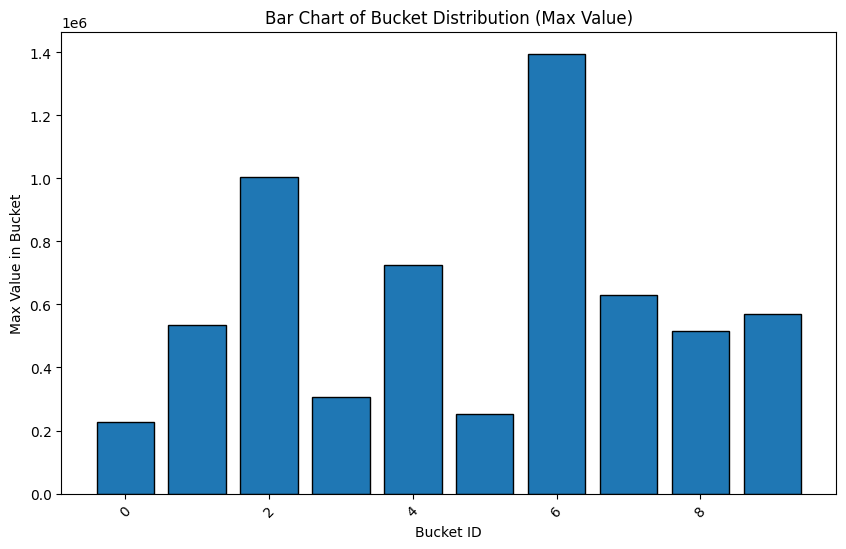

In [168]:
snapdf = pd.DataFrame(pd.DataFrame(bank.snapshot).max(), columns=['max'])
bucdf = pd.DataFrame(bank.bucket_usage_count, index=[0]).T
bucket_distribution = pd.concat([snapdf, bucdf], axis=1).rename(columns={0: 'usage_count'}).reset_index().rename(columns={'index': 'bucket_id'})

# ...existing code...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(bucket_distribution['bucket_id'])), bucket_distribution['max'], edgecolor='black')
plt.title('Bar Chart of Bucket Distribution (Max Value)')
plt.xlabel('Bucket ID')
plt.ylabel('Max Value in Bucket')
plt.xticks(rotation=45)
plt.show()

<Axes: title={'center': 'Cumulative PnL vs Exit Time'}, xlabel='exit_time'>

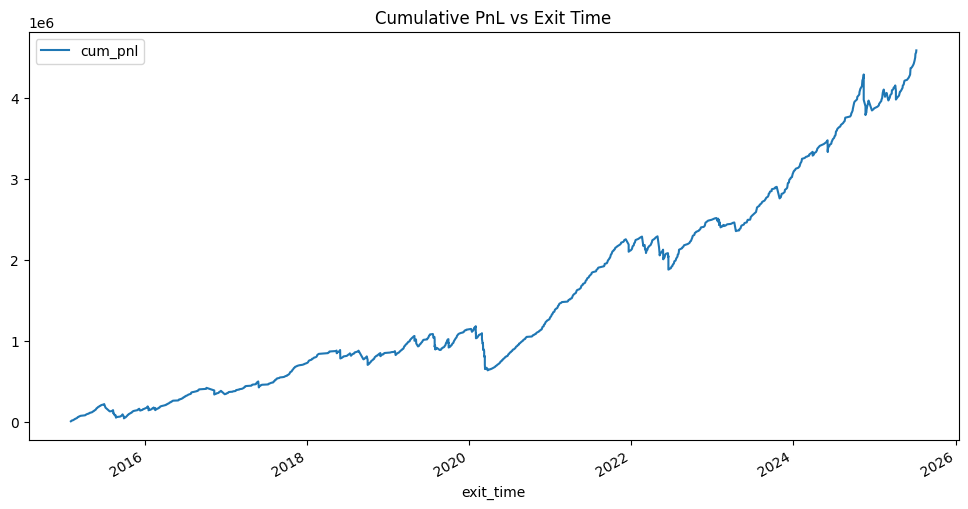

In [169]:
# ...existing code...
trades = trades.sort_values(['exit_time']).reset_index(drop=True)
trades['cum_pnl'] = trades['pnl'].cumsum()
trades.plot(x='exit_time', y='cum_pnl', title='Cumulative PnL vs Exit Time', figsize=(12, 6))

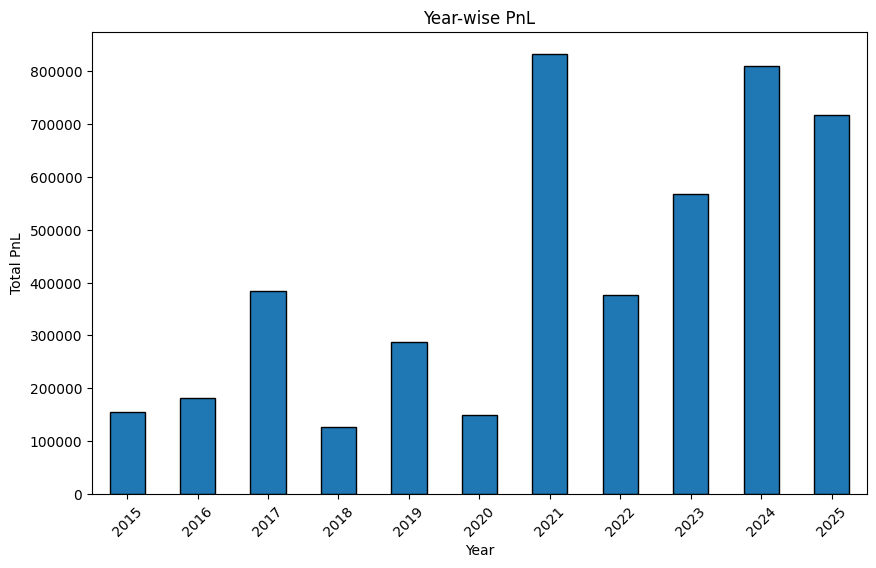

In [170]:
# ...existing code...
import matplotlib.pyplot as plt

# Extract year from exit_time
trades['exit_year'] = trades['exit_time'].dt.year

# Group by year and sum pnl
yearly_pnl = trades.groupby('exit_year')['pnl'].sum()

plt.figure(figsize=(10, 6))
yearly_pnl.plot(kind='bar', edgecolor='black')
plt.title('Year-wise PnL')
plt.xlabel('Year')
plt.ylabel('Total PnL')
plt.xticks(rotation=45)
plt.show()
#

In [171]:
losses = [c for c in closed_positions if c.pnl < 0]
losses_df = pd.DataFrame([asdict(p) for p in losses]).sort_values(['entry_time']).reset_index(drop=True)
losses_df.to_csv('losses.csv', index=False)